## Financial Time Series and Their Characteristics

Both financial theory and its empirical time series contain an element of uncertainty. For example, there are various definitions of asset volatility, and for a stock return series, __the volatility is not directly observable__. As a result of the added uncertainty, statistical theory and methods play an important role in financial time series analysis.

In this lecture, we will study:

* asset returns
* descriptive statistics of returns
* distributional properties of returns

In [81]:
import numpy as np
import scipy
import math
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

### The Time Value of Money

Future value, present value and simple interest:

$$FV_n = V(1+R) \times \cdots \times (1+R) = V \cdot (1+R)^n$$

$$PV = \frac{FV_n}{(1+R)^n}$$

$$n = \frac{\ln(FV_n /V)}{\ln(1+R)} $$

It is very easy to calculate how long it will take to double the value.

In [16]:
r = [r/100 for r in range(1, 11)]
year = [math.log(2)/math.log(1+i) for i in r]
appro_year = [0.7/i for i in r]  # rule of 70
print(tabulate(zip(r, year, appro_year), headers=['R', 'Years', "Approximate Years"]))

   R     Years    Approximate Years
----  --------  -------------------
0.01  69.6607              70
0.02  35.0028              35
0.03  23.4498              23.3333
0.04  17.673               17.5
0.05  14.2067              14
0.06  11.8957              11.6667
0.07  10.2448              10
0.08   9.00647              8.75
0.09   8.04323              7.77778
0.1    7.27254              7


When the return is around $0.1$ or around $10\%$, it takes around 7 years to double your assets.

If interest is paid $m$ times per year then the future value after $n$ years is

$$FV_n^m = V \cdot ( 1 + \frac{R}{m})^{m\cdot n}$$

For the continuously compouneded, we could have:

$$FV_n^c = \lim_{m \to \infty} V \cdot (1 + \frac{R}{m})^{m\cdot n} = V \cdot e ^{R \cdot n}$$

In [12]:
fre = [1, 4, 52, 365, 1_000]  # compounding frequency
r = 0.1  # interest is 10% at the end of year
v0 = 100  # initial value
fv = [v0*(1 + r/f)**(f*1) for f in fre]
print('The final value of 100 at the end of one year (n=1)')
print(tabulate(zip(fre, fv), headers=['Frequency', 'Value']))

The final value of 100 at the end of one year (n=1)
  Frequency    Value
-----------  -------
          1  110
          4  110.381
         52  110.506
        365  110.516
       1000  110.517


### Effective annual rate

We now consider the relationship between simple interest rates, periodic rates, effective annual rates and continuously compounded rates. Suppose an investment pays a periodic interest rate of $2\%$ each quater. This gives rise to a simple annual rate of $8\%$ ($2\% \times 4$ quarters). At the end of the year, $\$ 1000$ invested accrues to 

$$1000 \cdot ( 1 + \frac{0.08}{4})^{4 \cdot 1} = 1082.4$$

The _effective annual rate_, $R_A$, on the investment is determined by the relationship 

$$1000 \cdot (1 + R_{A}) = 1082.4$$

Solving for $R_A$ gives

$$R_A = \frac{1082.4}{1000} - 1 = 0.0824$$

Here, __the effective annual rate is the simple interest rate with annual compounding__ that gives the same future value that occurs with simple interest compounded four times per year. The formula is

$$R_A = (1 + \frac{R}{m})^m -1 $$

The relationship between the effective annual rate and the simple rate that is compounded continuously is

$$(1+R_A) = e^R$$

Hence, 

$$R_A = e^R - 1; \ \ \ \ \ \ R = \ln(1 + R_A)$$

### Asset Return Calculations

In this section, we review asset return calculations given initial and future prices associated with an investment. We first cover simple return calcualtions, which are typically reported in practice but are often not convinent for statistical modeling purposes. We then describe continuously compounded return calculations, which are more covinent for statistical modeling purposes.

In [107]:
# get the dataset
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2020-12-31'

appl_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
appl_data = appl_data.asfreq('B')  # frequency based on business day, this is very improtant
clean_data = appl_data.dropna().copy()

In [108]:
clean_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,7.619643,7.520000,7.611786,7.526071,352410800.0,6.482683
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.583586
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.594968
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.490066
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.478067
...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.773087
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.486053
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.668762


<AxesSubplot:xlabel='Date'>

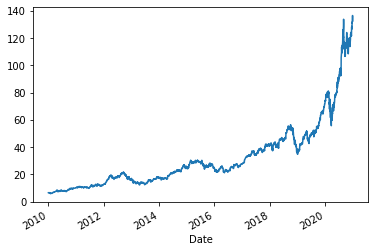

In [84]:
clean_data['Adj Close'].plot()

In [113]:
## prepare the dataset
clean_data['day'] = clean_data.index.day
clean_data['month'] = clean_data.index.month
clean_data['year'] = clean_data.index.year
clean_data['week_day'] = clean_data.index.dayofweek
clean_data['week_day_name'] = clean_data.index.strftime('%A')

In [133]:
clean_data.tail()

,High,Low,Open,Close,Volume,Adj Close,day,month,year,week_day,week_day_name
Date,,,,,,,,,,,
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.773087,24,12,2020,3,Thursday
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.486053,28,12,2020,0,Monday
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.668762,29,12,2020,1,Tuesday
2020-12-30,135.990005,133.399994,135.580002,133.720001,96452100.0,133.520477,30,12,2020,2,Wednesday
2020-12-31,134.740005,131.720001,134.080002,132.690002,99116600.0,132.492020,31,12,2020,3,Thursday


In [160]:
clean_data.isnull().values.any()

False

In [134]:
clean_data.to_csv("apple_stock.csv")

In [124]:
def total_return(prices):
    """Retuns the return between the first and last value of the DataFrame.
    Parameters
    ----------
    prices : pandas.Series or pandas.DataFrame
    Returns
    -------
    total_return : float or pandas.Series
        Depending on the input passed returns a float or a pandas.Series.
    """
    return prices.iloc[-1] / prices.iloc[0] - 1

In [153]:
group_data = clean_data.groupby(by=['year', 'month'])['Adj Close'].apply(total_return)
group_data

year  month
2009  12       0.000000
2010  1       -0.102565
      2        0.050788
      3        0.124455
      4        0.106454
                 ...   
2020  8        0.186668
      9       -0.136906
      10      -0.067900
      11       0.096400
      12       0.081242
Name: Adj Close, Length: 133, dtype: float64

<AxesSubplot:xlabel='year,month'>

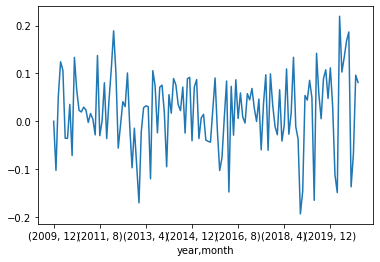

In [154]:
group_data.plot()

In [150]:
np.log(1 + group_data)  # monthly cc returns

year  month
2009  12       0.000000
2010  1       -0.108215
      2        0.049540
      3        0.117299
      4        0.101161
                 ...   
2020  8        0.171150
      9       -0.147231
      10      -0.070315
      11       0.092032
      12       0.078110
Name: Adj Close, Length: 133, dtype: float64

In [158]:
clean_data['Adj Close'].resample('M').ffill().pct_change()

Date
2009-12-31         NaN
2010-01-31   -0.088597
2010-02-28    0.065396
2010-03-31    0.148470
2010-04-30    0.111022
                ...   
2020-08-31    0.216569
2020-09-30   -0.102526
2020-10-31   -0.060012
2020-11-30    0.095493
2020-12-31    0.114574
Freq: M, Name: Adj Close, Length: 133, dtype: float64

In [164]:
np.log(clean_data['Adj Close'].resample('M').ffill().pct_change()+1)

Date
2009-12-31         NaN
2010-01-31   -0.092770
2010-02-28    0.063347
2010-03-31    0.138431
2010-04-30    0.105280
                ...   
2020-08-31    0.196035
2020-09-30   -0.108172
2020-10-31   -0.061888
2020-11-30    0.091205
2020-12-31    0.108472
Freq: M, Name: Adj Close, Length: 133, dtype: float64

`resample` method use the price of last of day of previous month to calculate the month return.

<AxesSubplot:xlabel='Date'>

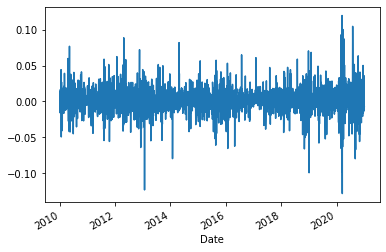

In [162]:
# daily return
clean_data['Adj Close'].pct_change().plot()

### References

Return Calculations by [Zivot](https://faculty.washington.edu/ezivot/econ424/returnCalculations.pdf)